<a href="https://colab.research.google.com/github/kimisuke0503/colab-research/blob/main/needs_scan_panel/needs_2d_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

needs_scan_panel/needs_2d_visualization.ipynb

In [1]:
import pandas as pd
import numpy as np
import sys
import random
import csv
from statistics import mean, median,variance,stdev

In [2]:
data_training = pd.read_csv('needs_scan_panel_training.csv', header=None)
data_test = pd.read_csv('needs_scan_panel_test.csv', header=None)
X_needs = data_training.values
test_needs = data_test.values
print(X_needs)
print(test_needs)

[[1 0 1 ... 1 1 0]
 [1 0 0 ... 1 0 1]
 [0 0 0 ... 1 0 0]
 ...
 [1 0 0 ... 1 0 0]
 [1 1 1 ... 1 0 0]
 [0 0 1 ... 1 0 0]]
[[  1   1   0]
 [  2   4   0]
 [  2   8   0]
 ...
 [993   1   0]
 [993   2   1]
 [995   8   0]]


寄与率: 
           0
0  0.126490
1  0.091551
累積寄与率: 
            0
0  0.126490
1  0.218041


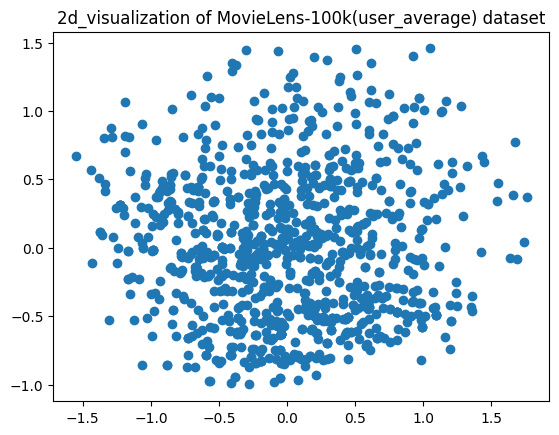

In [3]:
# PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

N_DIMENSIONS = 2

pca = PCA(N_DIMENSIONS) # 次元数を設定して初期化
# 次元削減
principalDf = pd.DataFrame(data=pca.fit_transform(X_needs), columns = ['principal component1', 'principal component2'])
# 寄与率を算出
contribution_ratios = pd.DataFrame(pca.explained_variance_ratio_)
cumulative_contribution_ratios = contribution_ratios.cumsum()

principalValue = principalDf.values # 主成分データ

print("寄与率: \n", contribution_ratios)
print("累積寄与率: \n ", cumulative_contribution_ratios)
plt.scatter(principalValue[:,0], principalValue[:,1])
plt.title("2d_visualization of MovieLens-100k(user_average) dataset")
plt.rcParams["font.size"] = 11
plt.savefig(f"ave_movie_2d_visualization.png", format="png", dpi=300)

In [ ]:
# 主成分考察

pv1 = principalValue[:,0]
pv2 = principalValue[:,1]

print(np.where(pv1<-1.5))
print(np.where(pv1>1.5))

print("全体の平均: ", np.average(X_needs))

user_average_score_min = np.average(X_needs[np.where(pv1<-1.5)], axis=1)
print(user_average_score_min)

user_average_score_max = np.average(X_needs[np.where(pv1>1.5)], axis=1)
print(user_average_score_max)

(array([169]),)
(array([  2, 109, 202, 284, 503, 703, 860, 946]),)
全体の平均:  0.5749107541276216
[1.]
[0.22222222 0.22222222 0.27777778 0.16666667 0.27777778 0.16666667
 0.33333333 0.22222222]


In [ ]:
def RSCCMM(X, C, delta):
  n, m = X.shape
  u = np.zeros((C,n))
  normalized_u = np.zeros((C,n))

  #要素の正規化
  #sys.float_info.epsilon を足してないと、類似度計算の時にlog(0)となってNaNが発生する
  # X = X + sys.float_info.epsilon
  # np.where(X == 0, sys.float_info.epsilon, X)
  normalized_X = X / np.sum(X, 1)[:, np.newaxis]

  #類似度
  s_it = np.array([np.sum(normalized_X * np.log(row + sys.float_info.epsilon), 1) for row in normalized_X])

  #二項関係
  #deltaの値が小さすぎると二項関係がなくなって、(※)式のところでゼロ徐算が発生する
  R = (s_it >= delta).astype(np.float64)

  #初期項目メンバシップ
  w = np.array([X[c] + sys.float_info.epsilon for c in random.sample(range(n), C)])
  w /= w.sum(1)[:,np.newaxis]

  #繰り返し処理
  for i in range(100):
    old_u = normalized_u.copy()
    u = np.zeros((C,n))
    normalized_u = np.zeros((C,n))

    #HCCMM的なクラスター割り当てによるメンバシップ
    s = np.log(w) @ X.T
    s_max = np.max(s, 0)
    u = (s >= s_max).astype(np.float64)

    #粒状性（二項関係）を考慮した上近似メンバシップ
    if(np.any(np.sum(R, 1) == 0)):
       raise Exception("二項関係がない")
    normalized_u = ((u @ R.T) / np.sum(R, 1) > 0).astype(np.float64) #(※)
    normalized_u /= normalized_u.sum(0)

    #正規化メンバシップ更新
    #ここでも微小値を足していないと次の類似度計算の時にNaNになって計算できなくなる
    w = (normalized_u @ X) + sys.float_info.epsilon
    if(np.any(np.isnan(w.sum(1)))):
      raise Exception("NaN発生")
    w /= w.sum(1)[:, np.newaxis]

    if np.abs(normalized_u - old_u).max() == 0:
      break

  return normalized_u.T @ w, (u @ R.T) / np.sum(R, 1)

In [ ]:
#roopの回数を指定し、最大のaucとその時のクラスター構造を返す関数(RSCCMM)
from sklearn.metrics import roc_auc_score

def RSCCMM_CF_AUC_CLUSTER(roop, test, X, C, delta):
  n, m = X.shape
  test_num, test_num_fact = test.shape
  auc_max = 0
  rm_max = 0

  test_true = np.zeros(test_num)
  r_test_score = np.zeros(test_num)

  for i in range(test_num):
    test_true[i] = test[i][2]

  for i in range(roop):
    r, rm = RSCCMM(X, C, delta) # RSCCM法を適用

    for j in range(test_num):
      r_test_score[j] = r[test[j][0]][test[j][1]]

    auc = roc_auc_score(test_true, r_test_score) # AUCを計算

    if auc > auc_max:
      auc_max = auc
      rm_max = rm


  return auc_max, rm_max

auc, rm = RSCCMM_CF_AUC_CLUSTER(10, test_needs, X_needs, 3, -7)
print("auc: ", auc)

auc:  0.8478055020267126


auc_max:  0.8515453684630208
delta_max:  -6.0


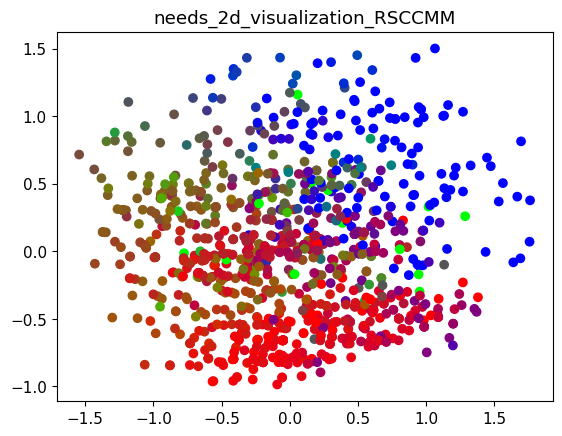

In [ ]:
name = "needs_2d_visualization_RSCCMM"
C = 3
loop = 10
delta_list = np.arange(-5, -9, -0.5)

auc_max = 0
rm_max = 0
delta_max = 0
for delta in delta_list:
  auc, rm = RSCCMM_CF_AUC_CLUSTER(10, test_needs, X_needs, C, delta)
  if auc > auc_max:
    auc_max = auc
    rm_max = rm
    delta_max = delta


print("auc_max: ", auc_max)
print("delta_max: ", delta_max)

# PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

N_DIMENSIONS = 2

pca = PCA(N_DIMENSIONS) # 次元数を設定して初期化
printcipalComponents = pca.fit_transform(X_needs)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])
principalValue = principalDf.values # 主成分データ


plt.scatter(principalValue[:,0], principalValue[:,1], color=rm_max.T)
plt.title(name)
plt.rcParams["font.size"] = 11
plt.savefig(f"{name}.png", format="png", dpi=300)

with open(f'{name}_rough_membership.csv', 'wt', encoding='utf-8', newline='') as fout:
    writer = csv.writer(fout)
    writer.writerows(rm_max)

output_info = [["auc", "delta"]]
output_info.append([auc_max, delta_max])
with open(f'{name}_info.csv', 'wt', encoding='utf-8', newline='') as fout:
    writer = csv.writer(fout)
    writer.writerows(output_info)